# Fun With Word2Vec: News Headlines

In [271]:
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [272]:
main_data = pd.read_csv('News_Final.csv')

In [273]:
main_data.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


# Preprocessing

We'll start by doing some cleaning and manipulation on the text data. In particular, we need to:
1. Get individual words from article titles
2. Use NLTK to filter out stopwords, punctuation, and any words that are not known to Word2Vec
3. Turn the words into vector representations using Word2Vec

In [274]:
# Grab all the article titles
article_titles = main_data['Title']
article_titles.shape

(93239,)

In [275]:
# Create a list of strings, where each string is an article title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['obama',
 'lays',
 'wreath',
 'arlington',
 'national',
 'cemetery',
 'look',
 'health',
 'chinese',
 'economy']

In [276]:
# Load Word2Vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size

300

What a word vector looks like:

In [277]:
economy_vec = model['economy']
economy_vec[:20] # First 20 components

array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

In [278]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

(21805, 300)

Now we have a bunch of tidy vectors in a DataFrame. Each column is the word's component for that dimension (300 dimensions total).

In [279]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
obama,-0.123535,0.072266,0.171875,0.402344,-0.125977,-0.302734,-0.044922,-0.015259,0.171875,-0.043457,...,-0.055420,-0.138672,-0.064453,-0.104004,-0.267578,-0.205078,-0.111816,-0.022461,0.066895,0.026855
lays,-0.052246,-0.057373,0.193359,-0.106934,0.298828,-0.166016,0.137695,0.125000,-0.032227,-0.096191,...,-0.172852,-0.484375,-0.228516,0.168945,-0.291016,0.003647,0.041016,0.229492,0.248047,0.353516
wreath,0.166992,0.199219,-0.082031,0.142578,0.055420,-0.102539,0.103516,-0.138672,0.030884,-0.007050,...,0.015503,-0.085938,-0.173828,0.109863,0.096680,-0.102051,0.119629,-0.287109,-0.085938,0.188477


# Dimensionality Reduction: t-SNE

Next, we're going to squish (read: do dimensionality reduction on) these word vectors using t-SNE. If you're not familiar with t-SNE and its interpretations, check out [this excellent, interactive distill.pub article](https://distill.pub/2016/misread-tsne/) on t-SNE. 

It's important to play around with the parameters for t-SNE, as different values can produce very different results. I tested several values between 0 and 100 for perplexity, and found that it produced roughly the same shape each time. I tested several learning rates between 20 and 400 as well, and decided to leave the learning rate at its default (200).

In [301]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

Now we're ready to plot our reduced array of word vectors and see what patterns we can find.

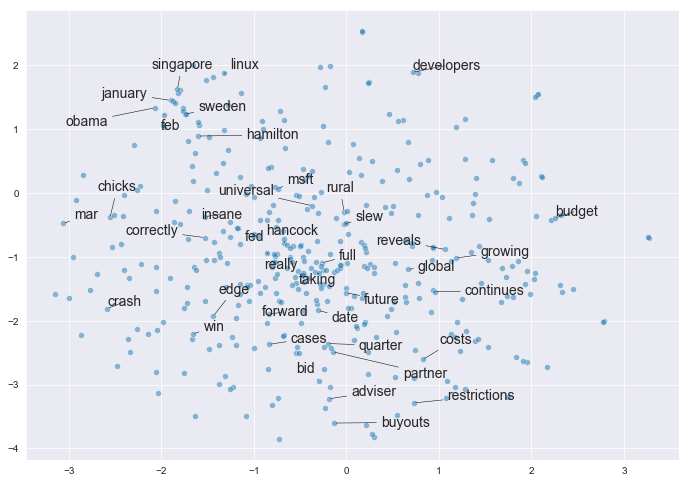

In [302]:
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Note that even though the text still overlaps some points, we no longer have overlapping text. Nifty! 

If you're interested in trying out `adjust_text` for your own plotting needs, you can find it [here](https://github.com/Phlya/adjustText). Be sure to import using the camelcase `adjustText`.

It's encouraging to see that even when the vector embeddings have been reduced to 2 dimensions, we see certain items clustering together. For example, we have **months** in the left/upper left, we have **corporate finance terms** near the bottom, and we have more **generic, non-topical words** (like 'full', 'really', 'slew') in the middle.

Note that if we were to run the t-SNE again with different parameters, we may observe some similarities to this result, but we're not guaranteed to see the exact same patterns. t-SNE, as compared to PCA, is not deterministic. Relatedly, tightness of clusters and distances between clusters are not always meaningful. It is meant primarily as an exploratory tool, rather than as a decisive indicator of similarity. 

# Averaging Word Embeddings 

We've gotten a sense of how word embeddings work as applied to this dataset. Now we can move on to some more interesting ML applications: finding titles that cluster together, and seeing what patterns emerge.

Instead of using Doc2Vec, which would require a lengthy training process, we can use a simpler [(and sometimes even more effective)](https://stackoverflow.com/questions/45234310/doc2vec-worse-than-mean-or-sum-of-word2vec-vectors) trick: averaging the embeddings of the word vectors in each document. In our case, a document refers to a title or a headline. 

In [283]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [284]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

37 docs removed
0 docs removed


In [286]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

Procedure and functions adapted from [this notebook](https://github.com/sdimi/average-word2vec/blob/master/notebook.ipynb) by Dimitris Spathis.

# t-SNE for Document Vectors

In [303]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])

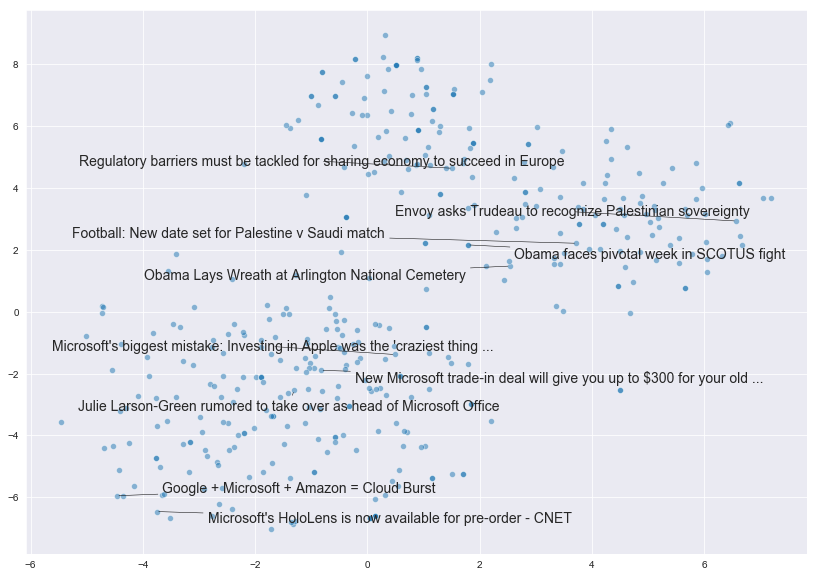

In [304]:
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Pretty interesting! We can see that the t-SNE has collapsed the document vectors into a dimensional space where a higher y-value means the document has more to do with countries, world leaders, and foreign affairs, and a lower y-value means the document has more to do with technology companies. 